## Price analysis

I decided to use inforprice.by service as source about prices for products in Belarus TOP retailers stores. Cause there is no any open sources about prices in Belarus.

So, this notebook have next table of contents:
1. [Download data from inforprice.by API](#api)
2. [Data processing](#processing)

<a id='api'></a>
### 1. Downloading data from infopirce.by API

Firstly we have to import necessary libraries:
- **`requests`** - send request to API
- **`json`** and **`pandas`** - process response from API

In [1]:
import requests
import json
from datetime import date
import pandas as pd

Here we prepare some variables for request payload:
- **`url`** - url address of infoprice.by API
- **`cats`** - categories to download (if not set we will get only little bunch of data from API)
- **`headers`**

I decided to investigate prices at Juices category, that's why i need to download those categories:
- **`3368`** - Juices, nectars, morses, syrups
- **`3475`** - **Juices**, purees, canned food, water, tea, cookies, soups, and other baby stuff

In [2]:
url = "https://api.infoprice.by/InfoPrice.Goods"
today = date.today()
d1 = today.strftime("%d.%m.%y")
cats = [3368, 3475]
headers = {'Content-Type': 'application/json'}

Due to feature of infoprice.by API requesting data is provided by pages. That's why we need to define functions that will go through all categories in **`cats`** variable and all pages in it category:
- function **`postByPages`** described below is going through pages in categories
- function **`postByCat`**:
    - gets info about category (number of pages)
    - going through loop by categories and start **`postByPages`** func
    - processing responses from *json* to *pandas dataframe*

*`here we running script in one thread cause there is a reason of unexpected crashes of infoprice.by API.`*

In [3]:
def postByPages (cat , numPages, url, promo):
    try:
        global allPages
        for i in range(numPages):
            i=i+1
            payload = '{ "CRC":"","Packet": {"FromId": "10003001", \
                                             "ServerKey": "omt5W465fjwlrtxcEco97kew2dkdrorqqq", \
                                             "Data": {"ContractorId":"", \
                                                      "GoodsGroupId": "'+str(cat)+'", \
                                                      "Page":"'+str(i)+'", \
                                                      "Search":"", \
                                                      "OrderBy":0, \
                                                      "OrderByContractor": 0, \
                                                      "CompareСontractorId": 72517, \
                                                      "CatalogType": 0, \
                                                      "IsPromotionalPrice":'+str(promo)+' \
                                                     } \
                                            } \
                        }'
            addPage = requests.request("POST", url, headers=headers, data = payload.encode('utf-8'))
            dataPage = json.loads(addPage.text)
            if i == 1:
                allPages = dataPage
                #print('done '+str(i)+' page of ' + str(numPages)+' in '+str(cat)+' category')
            else:
                allPages['Table'][0]['GoodsOffer'] += dataPage['Table'][0]['GoodsOffer'][:]
                #print('done '+str(i)+' page of ' + str(numPages)+' in '+str(cat)+' category')
    except(IndexError):
        print('error error')
        
def postByCat (cats, url, promo):
    for j in range(len(cats)):
        payload = '{ "CRC":"","Packet": {"FromId": "10003001", \
                                         "ServerKey": "omt5W465fjwlrtxcEco97kew2dkdrorqqq", \
                                         "Data": {"ContractorId":"", \
                                                  "GoodsGroupId": "'+str(cats[j])+'", \
                                                  "Page":"", \
                                                  "Search":"", \
                                                  "OrderBy": 0, \
                                                  "OrderByContractor": 0, \
                                                  "CompareСontractorId": 72517, \
                                                  "CatalogType": 0, \
                                                  "IsPromotionalPrice":'+str(promo)+' \
                                                 } \
                                        } \
                    }'
        response = requests.request("POST", url, headers=headers, data = payload.encode('utf-8'))
        data = json.loads(response.text)
        numPages = data['Table'][0]['GeneralData'][0]['AmountPages']
        cat = cats[j]
        postByPages(cat , numPages, url, promo)
        if j == 0:
            result = pd.json_normalize(allPages['Table'][0]['GoodsOffer'][:], 'Offers', ['GoodsId','GoodsName', 'GoodsGroupName'])
            print('done '+str(j+1)+' category of ' + str(len(cats)))
        else:
            result = pd.concat([result,pd.json_normalize(allPages['Table'][0]['GoodsOffer'][:], 'Offers', ['GoodsId','GoodsName', 'GoodsGroupName'])])
            print('done '+str(j+1)+' category of ' + str(len(cats)))
        j=j+1
        
    contractors = pd.json_normalize(data['Table'][0]['TradingCompany'])
    contractors = contractors[['ContractorId','ContractorName']]
    results = pd.merge(result, contractors, on ='ContractorId', how ='inner')
    #results.to_excel('infoprice_'+str(d1)+'.xls')
    #with open('infoprice_'+str(d1)+'.json', 'w') as json_file:
    #    json.dump(allPages, json_file)
    return results

In [4]:
df = postByCat(cats,url,0)
df_promo = postByCat(cats,url,1)

df_promo = df_promo[df_promo.IsPromotionalPrice == 1]
df_promo = df_promo[["ContractorId", "GoodsId"]]

df = pd.merge(df, df_promo, on=['ContractorId','GoodsId'], how="outer", indicator=True)
df = df[df['_merge'] == 'left_only']
df = df.drop(['_merge'], axis=1)

done 1 category of 2
done 2 category of 2
done 1 category of 2
done 2 category of 2


As soon as all categories were processed we can check downloaded data.

In [5]:
df.head(10)

,Price,ContractorId,MonitoringDate,AddressShop,GoodsPhotoPrice,IsPromotionalPrice,GoodsId,GoodsName,GoodsGroupName,ContractorName
0,2.59,72471,22.11.2022,ostrov-shop.by,00000118535494.png,-1,712361,"Сок ""Сочный фрукт"" томатный с солью 1л РБ","Соки, нектары, морсы, сиропы",Остров Чистоты
1,2.96,72471,22.11.2022,ostrov-shop.by,00000118535642.png,-1,1205694,Сок березовый негазированный 1л ПЭТ МЗБН,"Соки, нектары, морсы, сиропы",Остров Чистоты
2,6.20,72471,22.11.2022,ostrov-shop.by,00000118537083.png,-1,640169,"Сок гранатовый ""Telli grand"" прямого отжима 1л...","Соки, нектары, морсы, сиропы",Остров Чистоты
3,18.99,72471,22.11.2022,ostrov-shop.by,00000118539053.png,-1,1355183,"Сироп сахарный ароматизированный ""Jolly jocker...","Соки, нектары, морсы, сиропы",Остров Чистоты
4,18.99,72471,22.11.2022,ostrov-shop.by,00000118539051.png,-1,1355186,"Сироп сахарный ароматизированный ""Jolly jocker...","Соки, нектары, морсы, сиропы",Остров Чистоты
5,18.99,72471,22.11.2022,ostrov-shop.by,00000118539050.png,-1,1355194,"Сироп сахарный ароматизированный ""Jolly jocker...","Соки, нектары, морсы, сиропы",Остров Чистоты
6,2.07,72471,22.11.2022,ostrov-shop.by,00000118535249.png,-1,1183040,"Сок ""Yesta"" фруктово-ягодная поляна 1л","Соки, нектары, морсы, сиропы",Остров Чистоты
7,18.99,72471,22.11.2022,ostrov-shop.by,00000118539052.png,-1,1355184,"Сироп сахарный ароматизированный ""Jolly jocker...","Соки, нектары, морсы, сиропы",Остров Чистоты
8,3.49,72471,22.11.2022,ostrov-shop.by,00000118535886.png,-1,636182,"Сок ""Дары Кубани"" томатный 1л","Соки, нектары, морсы, сиропы",Остров Чистоты
9,0.76,72471,22.11.2022,ostrov-shop.by,00000118534644.png,-1,705076,"Вода питьевая ""Светлячок"" для детей негазирова...","Соки, пюре, консервы, вода, чай, печенье, супы...",Остров Чистоты


<a id='processing'></a>
### 2. Data processing

Okay, we got necessary information about prices by products and by retailers. But currently we can't make any price analysis cause stored data is not clean.
> We have categories (column `GoodsGroupName`) that contains different products with different flavors or even packsizes (e.g. drinking yogurts and milkshakes are stored in one category)

So that's why i decided to get additional data that stored in `GoodsName` like:
- **product type**
    - drinking yogurts, milkshakes, potato chips, crisp bread, juices etc.
- **brand name**
    - Sandora, Rich, Lay's, Agusha, XrusTeam, Cheetos etc.
- **pack size**
    - 1L, 75g, 200ml, 0.21kg etc.
- **flavors**
    - Lay's with paprika, apple juice, strawberry milkshake etc.

To solve this task i used regular expressions (`re` library).

#### 2.1 Define Pack Size

In [6]:
import re

pack_ptrn = re.compile(r'(\d+[.]*\d*)([a-zA-Zа-яА-ЯёЁ]+\b)')

def packvolume(pattern,string):
    match = pattern.search(string, re.M)
    if match:
        res = match.group(1)
    else:
        res = ""
    return res

def packmetric(pattern,string):
    match = pattern.search(string, re.M)
    if match:
        res = match.group(2)
    else:
        res = ""
    return res

df['PackVolume'] = [packvolume(pack_ptrn,x) for x in df.GoodsName.values]
df['PackMetric'] = [packmetric(pack_ptrn,x) for x in df.GoodsName.values]

c = ['г', 'л', 'кг', 'мл']
df = df[df.PackMetric.str.lower().isin(c)]

#### 2.2 Define Product Subcategory

In [7]:
prod_types = ['нектар', 'морс', 'сок']

def product_type(prod_list,string):
    for x in prod_list:
        if (string.lower().find(x)) != -1:
            res = x
            break
        else:
            res = ""
    return res.capitalize()

df['ProdType'] = [product_type(prod_types,x) for x in df.GoodsName.values]
df = df[df.ProdType != '']

#### 2.3 Define Brand Names

In [8]:
# get brand names

brand_ptrn = re.compile(r'(?<=\")[\w ]*(?=\")')

def brandname(pattern,string):
    match = pattern.search(string)
    if match:
        res = match.group(0)
    else:
        res = ""
    return res.lower().title()

df['BrandName'] = [brandname(brand_ptrn,x) for x in df.GoodsName.values]

# analysis is made for brands listed below

brands = ['Сочный Фрукт', 'Агуша', 'Беллакт', 'Маленькое Счастье',\
          'Сады Придонья', 'Маша И Медведь', 'Непоседа', 'Фрутоняня',\
          'Villa Dini', 'Joy', 'Аbc', 'Добрый', 'Садочок', 'Сочный Витамин',\
          'Rich', 'Сочный', 'Sandora', 'Abc', 'Сочный Морс', 'J7 Тонус',\
          'Сандора', 'Aвс', 'Топтышка', 'Gerber', \
          'Ложка В Ладошке', 'Bambolina', 'Фрутоkids', 'Дары Придонья',\
          'J7', 'Мой', 'Я', 'Сады Придон', 'Бусёнок']

# some_additional mapping to clean data

real_brands = ['Сочный Фрукт', 'Агуша', 'Беллакт', 'Маленькое Счастье',\
               'Сады Придонья', 'Маша И Медведь', 'Непоседа', 'Фрутоняня',\
               'Villa Dini', 'Joy', 'ABC', 'Добрый', 'Садочок', 'Сочный Витамин',\
               'Rich', 'Сочный', 'Sandora', 'ABC', 'Сочный Морс', 'J7 Тонус', \
               'Sandora', 'ABC', 'Топтышка', 'Gerber', \
               'Ложка В Ладошке', 'Bambolina', 'Фрутоkids', 'Дары Придонья',\
               'J7', 'Мой', 'Я', 'Сады Придонья', 'Бусёнок']

brands_mapping = {'BrandName': brands, 'RealBrand': real_brands} 
brands_mapping = pd.DataFrame(brands_mapping)

df = pd.merge(df, brands_mapping, on=['BrandName'], how="inner")
df = df.drop(['BrandName'], axis=1)

#### 2.4 Get Flavours

In [9]:
import Levenshtein

flavors = ['томатный', 'березовый', 'гранат', 'дыня',\
           'малина', 'мохито', 'фруктово-ягодный', 'кокос', 'яблоко',\
           'мультифрукт', 'мультивитамин', 'вишня', 'апельсин',\
           'грейпфрут', 'ананас', 'мультиовощной',\
           'виноград', 'абрикос', 'манго', 'соль', 'голубика',\
           'черника', 'банан', 'груша', 'персик', 'клубника', 'киви',\
           'шиповник', 'морс', 'тыква', 'морковь']

def flvrFunc(flvr_list,string):
    list_w = []
    list_x = []
    list_ratio = []
    list_check = []
    words = re.split(' |-|\(|\/|\)', string)
    for w in words:
        w = w.lower().replace('ый','')
        for x in flvr_list:
            res = Levenshtein.ratio(x,w)
            list_w.append(w)
            list_x.append(x)
            list_ratio.append(res)
            list_check.append(w.find(x[0:4]))
            #if w.find('мульти') >=0:
            #    list_check.append(w.find(x.replace('мульти','')[0:4]))
            #else:
            #    list_check.append(w.find(x[0:4]))
            #print('Levenshtein ratio of ' + str(x) + ' to ' + str(w) + ' is ' + str(res))#print('Levenshtein ratio of ' + str(x) + ' to ' + str(w) + ' is ' + str(res))
        df_ratio = pd.DataFrame(
            {'SentWord': list_w,
             'FlvrWord': list_x,
             'Ratio': list_ratio,
             'FindCheck': list_check
            })
    res = df_ratio[(df_ratio.FindCheck==0) & (df_ratio.Ratio>=0.65)].FlvrWord.tolist()
    res = ', '.join(res)
    return res

df['Flavors'] = [flvrFunc(flavors,x) for x in df.GoodsName.values]
df = df[df.Flavors != '']

In [10]:
df.head(5)

,Price,ContractorId,MonitoringDate,AddressShop,GoodsPhotoPrice,IsPromotionalPrice,GoodsId,GoodsName,GoodsGroupName,ContractorName,PackVolume,PackMetric,ProdType,RealBrand,Flavors
0,2.59,72471,22.11.2022,ostrov-shop.by,00000118535494.png,-1,712361,"Сок ""Сочный фрукт"" томатный с солью 1л РБ","Соки, нектары, морсы, сиропы",Остров Чистоты,1,л,Сок,Сочный Фрукт,"томатный, соль"
1,3.38,72512,14.11.2022,"ул. Кальварийская, 24",00000118359612.png,-1,712357,"Нектар ""Сочный фрукт"" мультивитамин 1л РБ","Соки, нектары, морсы, сиропы",Корона,1,л,Нектар,Сочный Фрукт,мультивитамин
2,3.38,72512,14.11.2022,"ул. Кальварийская, 24",00000118359783.png,-1,712363,"Нектар ""Сочный фрукт"" яблоко виноград 1л РБ","Соки, нектары, морсы, сиропы",Корона,1,л,Нектар,Сочный Фрукт,"яблоко, виноград"
3,5.72,72512,14.11.2022,"ул. Кальварийская, 24",00000118359577.png,-1,480843,"Нектар ""Сочный фрукт"" мультифрукт 1.95л РБ","Соки, нектары, морсы, сиропы",Корона,1.95,л,Нектар,Сочный Фрукт,мультифрукт
4,5.72,72512,14.11.2022,"ул. Кальварийская, 24",00000118359582.png,-1,484276,"Нектар ""Сочный фрукт"" яблоко виноград 1.95л РБ","Соки, нектары, морсы, сиропы",Корона,1.95,л,Нектар,Сочный Фрукт,"яблоко, виноград"


In [11]:
cols = ['ContractorName',
        'ContractorId',
        'AddressShop',
        'MonitoringDate',
        'GoodsGroupName',
        'ProdType',
        'RealBrand',
        'Flavors',
        'PackVolume',
        'PackMetric',
        'GoodsName',
        'GoodsId',
        'IsPromotionalPrice',
        'Price',
        'GoodsPhotoPrice']

df = df.reindex(columns=cols)
df = df.reset_index()
df = df.drop(['GoodsPhotoPrice', 'index', 'IsPromotionalPrice'], axis=1)

df.rename(columns = {'ContractorName':'store',
                     'ContractorId':'store_id',
                     'AddressShop':'store_address',
                     'MonitoringDate':'monitoring_date',
                     'GoodsGroupName':'category',
                     'ProdType' : 'subcategory',
                     'RealBrand' : 'brand_name',
                     'Flavors' : 'flavor',
                     'PackVolume' : 'pack_volume',
                     'PackMetric' : 'pack_metric',
                     'GoodsName':'product_name',
                     'GoodsId':'product_id',
                     'Price':'price'},
          inplace = True)

And finally before we start use data we should clean it from *outliners*.

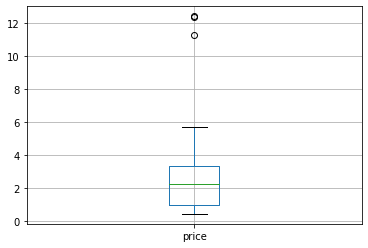

In [12]:
df['price'] = df['price'].astype(float)
df.boxplot(column="price")

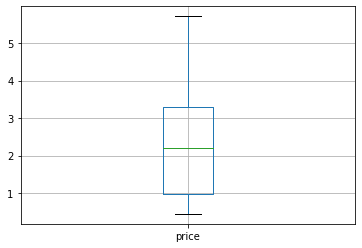

In [13]:
Q1 =  df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['price'] > (Q1-1.5*IQR)) & (df['price'] < (Q3+1.5*IQR))]
df.boxplot(column="price")

In [14]:
from itables import init_notebook_mode, show
import itables.options as opt
init_notebook_mode(all_interactive=True, connected=True)
opt.lengthMenu = [5, 10, 20, 50, 100, 200, 500]
opt.maxBytes = 0

show(df, column_filters="footer", dom="lrtip")

In [16]:
# make output to excel file

df.to_excel('juices_category'+'.xls')